In [1]:
%load_ext autoreload

In [3]:
%autoreload 2
import h5py
from hydra import initialize, compose
from hydra.utils import instantiate
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import get_section_info
from UniversalUnconsciousness.hdf5_utils import *



In [5]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
data_class = cfg.params.data_class
session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
# session_list = [session for session in session_list if 'Dex' not in session]
session_list = [session for session in session_list if 'Dex' in session]


In [10]:
session_responses = {}
for session in tqdm(session_list):
    # ------------------------------
    # Setup
    # ------------------------------
    section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    section_info_dict = {name: times for name, times in section_info}

    noise_filter_info = {}

    noise_filter_dir = os.path.join(cfg.params.noise_filter_results_dir, cfg.params.data_class)
    os.makedirs(noise_filter_dir, exist_ok=True)
    noise_filter_file = f"{session}__window_{cfg.params.window}__wakethresh_{cfg.params.wake_amplitude_thresh}__anesthesiathresh_{cfg.params.anesthesia_amplitude_thresh}__electrodenum_{cfg.params.electrode_num_thresh}.pkl"

    if noise_filter_file in os.listdir(noise_filter_dir):
        noise_filter_info[session] = pd.read_pickle(os.path.join(noise_filter_dir, noise_filter_file))
    else:
        print("Finding noisy data...")
        window_df, bad_electrodes, valid_window_starts = find_noisy_data(cfg, session)
        noise_filter_info[session] = dict(
            window_df=window_df,
            bad_electrodes=bad_electrodes,
            valid_window_starts=valid_window_starts
        )
        pd.to_pickle(noise_filter_info[session], os.path.join(noise_filter_dir, noise_filter_file))
    session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{session}.mat"))

    # ------------------------------
    # Get trial variables
    # ------------------------------
    task_types = convert_h5_string_array(session_file, session_file['trialInfo']['task'])
    trial_starts = session_file['trialInfo']['trialStart'][:, 0]
    trial_ends = session_file['trialInfo']['trialEnd'][:, 0]

    odd_tone_onsets = session_file['trialInfo']['odd_toneOnsets'][:, 0]
    odd_tone_offsets = session_file['trialInfo']['odd_toneOffsets'][:, 0]

    odd_sequence_start = session_file['trialInfo']['odd_sequenceStart'][:, 0]
    odd_sequence_end = session_file['trialInfo']['odd_sequenceEnd'][:, 0]

    oddball_trial_starts = trial_starts[task_types == 'oddball']
    oddball_trial_ends = trial_ends[task_types == 'oddball']

    odd_sequence = convert_h5_string_array(session_file, session_file['trialInfo']['odd_sequence'])
    unique_sequences = np.unique(odd_sequence)

    lvr_tone_onsets = session_file['trialInfo']['lvr_toneOnset'][:, 0]
    lvr_tone_offsets = session_file['trialInfo']['lvr_toneOffset'][:, 0]

    lvr_outcome = convert_h5_string_array(session_file, session_file['trialInfo']['lvr_outcome'])
    binary_outcome = [outcome == 'correct' for outcome in lvr_outcome]

    lfp = TransposedDatasetView(session_file['lfp']).transpose()
    dt = session_file['lfpSchema']['smpInterval'][0, 0]

    valid_electrodes = np.arange(lfp.shape[1])[~np.isin(np.arange(lfp.shape[1]), noise_filter_info[session]['bad_electrodes'])]

    valid_window_starts = noise_filter_info[session]['valid_window_starts']
    valid_window_ends = valid_window_starts + cfg.params.window

    # ------------------------------
    # Lever tone responses
    # ------------------------------

    leadup = 250
    response = 250
    start_times = lvr_tone_onsets
    end_times = lvr_tone_offsets

    # First pass - count number of valid tones per section
    section_tone_counts = {
        "awake lever1": 0,
        "early unconscious": 0
    }

    # Check which tones are valid and count them per section
    for start_time, end_time in zip(start_times, end_times):
        # Check if tone is in a valid recording window
        in_valid_window = False
        for valid_start, valid_end in zip(valid_window_starts, valid_window_ends):
            if start_time >= valid_start and end_time <= valid_end:
                in_valid_window = True
                break
        
        if in_valid_window:
            # Check which section this tone belongs to
            for section, times in section_info_dict.items():
                if section in section_tone_counts.keys():
                    if start_time >= times[0]*60 + infusion_start and end_time <= times[-1]*60 + infusion_start:
                        section_tone_counts[section] += 1

    # Initialize arrays with correct sizes
    tone_lfps = {
        section: np.empty((count, leadup + response, len(valid_electrodes)))
        for section, count in section_tone_counts.items()
    }

    # Reset counters for filling arrays
    tone_counts = {section: 0 for section in section_tone_counts.keys()}

    # Second pass - fill arrays
    for start_time, end_time in zip(start_times, end_times):
        # Check if tone is in a valid recording window
        in_valid_window = False
        for valid_start, valid_end in zip(valid_window_starts, valid_window_ends):
            if start_time >= valid_start and end_time <= valid_end:
                in_valid_window = True
                break
                
        if in_valid_window:
            for section, times in section_info_dict.items():
                if section in tone_lfps:
                    if start_time >= times[0]*60 + infusion_start and end_time <= times[-1]*60 + infusion_start:
                        index = tone_counts[section]
                        tone_lfps[section][index] = lfp[int(start_time/dt) - leadup:int(start_time/dt) + response, valid_electrodes]
                        tone_counts[section] += 1

    session_responses[session] = tone_lfps


  0%|          | 0/32 [00:00<?, ?it/s]

In [11]:
# Organize sessions by monkey and dose
organized_session_responses = {
    'PEDRI': {'low': {}, 'high': {}},
    'SPOCK': {'low': {}, 'high': {}}
}

for session, responses in session_responses.items():
    session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{session}.mat"))
    monkey = session.split('_')[0]
    dose = session_file['sessionInfo']['dose'][0, 0]
    if dose == 1.0 or dose == 5.0:
        dose = 'low'
    else:
        dose = 'high'
    organized_session_responses[monkey][dose][session] = responses


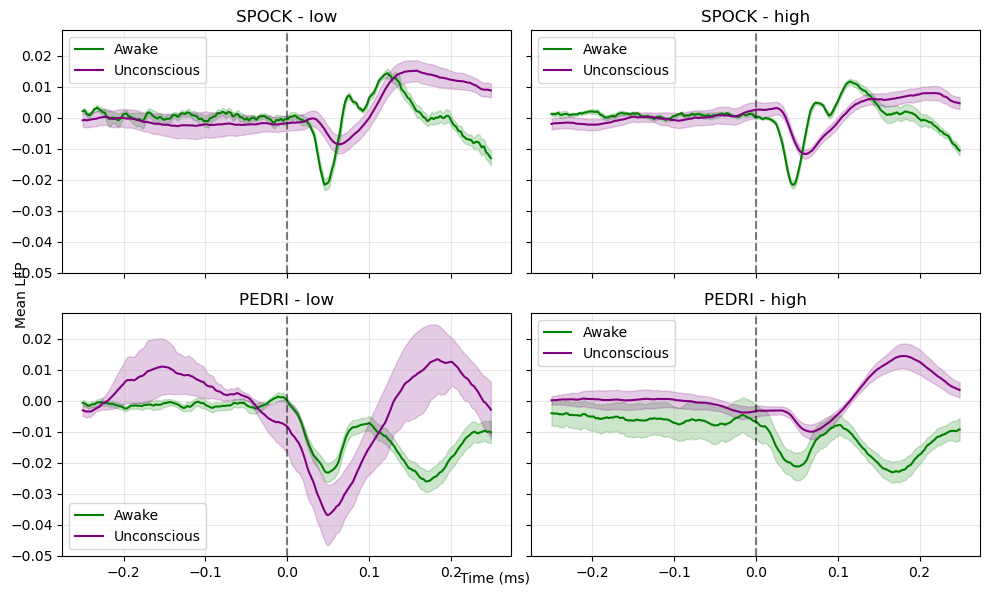

In [13]:
# Create figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()

# Time axis in ms (-500 to +500 ms)
time = np.arange(-leadup, response)*dt

# Plot each monkey/dose combination
for idx, (monkey, doses) in enumerate(organized_session_responses.items()):
    for dose in doses.keys():
        if monkey == 'SPOCK':
            ax_idx = 0 if dose == 'low' else 1
        else:  # PEDRI
            ax_idx = 2 if dose == 'low' else 3
            
        # Collect all responses for this monkey/dose
        awake_responses = []
        unconscious_responses = []
        
        for session_responses in doses[dose].values():
            if 'awake lever1' in session_responses:
                awake_responses.append(session_responses['awake lever1'].mean(axis=(0, 2)))  # Average across electrodes
            if 'awake lever2' in session_responses:
                awake_responses.append(session_responses['awake lever2'].mean(axis=(0, 2)))  # Average across electrodes
            if 'early unconscious' in session_responses:
                unconscious_responses.append(session_responses['early unconscious'].mean(axis=(0, 2)))

        # Convert to arrays and calculate mean and SEM
        if awake_responses:
            awake_mean = np.mean(np.vstack(awake_responses), axis=0)
            awake_sem = np.std(np.vstack(awake_responses), axis=0) / np.sqrt(np.vstack(awake_responses).shape[0])
            axs[ax_idx].plot(time, awake_mean, color='green', label='Awake')
            axs[ax_idx].fill_between(time, awake_mean-awake_sem, awake_mean+awake_sem, 
                                   color='green', alpha=0.2)
            
        if unconscious_responses:
            unconscious_mean = np.mean(np.vstack(unconscious_responses), axis=0)
            unconscious_sem = np.std(np.vstack(unconscious_responses), axis=0) / np.sqrt(np.vstack(unconscious_responses).shape[0])
            axs[ax_idx].plot(time, unconscious_mean, color='purple', label='Unconscious')
            axs[ax_idx].fill_between(time, unconscious_mean-unconscious_sem, 
                                   unconscious_mean+unconscious_sem, color='purple', alpha=0.2)
        
        axs[ax_idx].set_title(f'{monkey} - {dose}')
        axs[ax_idx].axvline(x=0, color='k', linestyle='--', alpha=0.5)
        axs[ax_idx].grid(True, alpha=0.3)
        axs[ax_idx].legend()

# Add common labels
fig.text(0.5, 0.02, 'Time (ms)', ha='center')
fig.text(0.02, 0.5, 'Mean LFP', va='center', rotation='vertical')

plt.tight_layout()
plt.show()


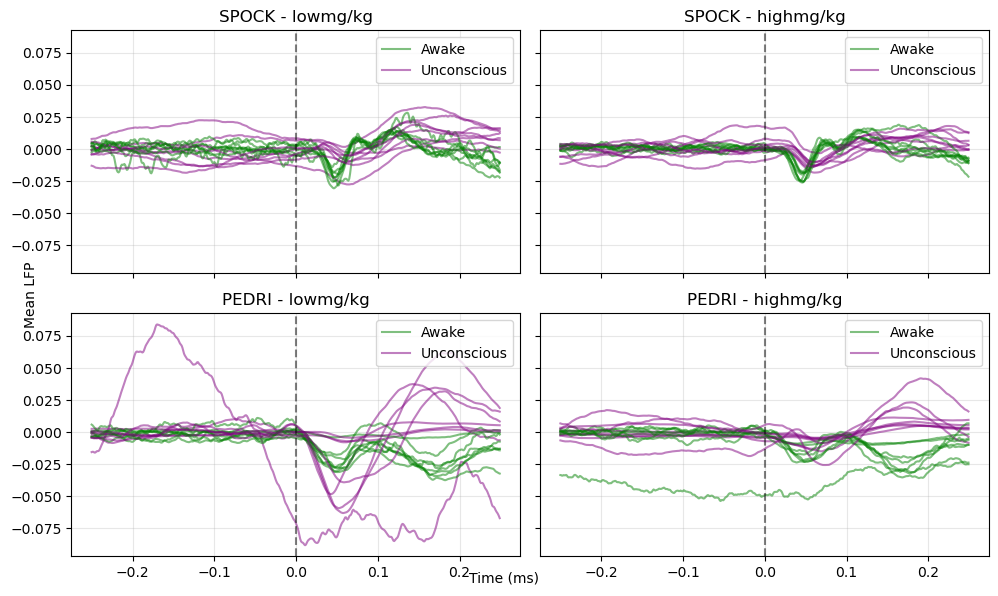

In [16]:
# Create figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()

# Time axis in ms (-500 to +500 ms)
time = np.arange(-leadup, response)*dt

# Plot each monkey/dose combination
for idx, (monkey, doses) in enumerate(organized_session_responses.items()):
    for dose in doses.keys():
        if monkey == 'SPOCK':
            ax_idx = 0 if dose == 'low' else 1
        else:  # PEDRI
            ax_idx = 2 if dose == 'low' else 3
            
        # Collect all responses for this monkey/dose
        for session_responses in doses[dose].values():
            if 'awake lever1' in session_responses:
                awake_response = session_responses['awake lever1'].mean(axis=(0, 2))  # Average across electrodes
                axs[ax_idx].plot(time, awake_response, color='green', alpha=0.5)  # Plot each session

            if 'awake lever2' in session_responses:
                awake_response = session_responses['awake lever2'].mean(axis=(0, 2))  # Average across electrodes
                axs[ax_idx].plot(time, awake_response, color='green', alpha=0.5)  # Plot each session
            
            if 'early unconscious' in session_responses:
                unconscious_response = session_responses['early unconscious'].mean(axis=(0, 2))
                axs[ax_idx].plot(time, unconscious_response, color='purple', alpha=0.5)  # Plot each session

        axs[ax_idx].set_title(f'{monkey} - {dose}mg/kg')
        axs[ax_idx].axvline(x=0, color='k', linestyle='--', alpha=0.5)
        axs[ax_idx].grid(True, alpha=0.3)
        axs[ax_idx].legend(['Awake', 'Unconscious'], loc='upper right')

# Add common labels
fig.text(0.5, 0.02, 'Time (ms)', ha='center')
fig.text(0.02, 0.5, 'Mean LFP', va='center', rotation='vertical')

plt.tight_layout()
plt.show()


In [19]:
n_delays = 10
delay_interval = 5
responses_etdc = {}

for monkey in organized_session_responses.keys():
    responses_etdc[monkey] = {}
    for dose in organized_session_responses[monkey].keys():
        responses_etdc[monkey][dose] = {
            'awake': [],
            'unconscious': []
        }
        for session in organized_session_responses[monkey][dose].keys():
            for section in organized_session_responses[monkey][dose][session]:
                responses = organized_session_responses[monkey][dose][session][section]
                responses_de = embed_signal_torch(responses, n_delays, delay_interval)
                pca = PCA(n_components=2).fit(responses_de.mean(axis=0))
                if 'awake' in section:
                    responses_etdc[monkey][dose]['awake'].append(pca.transform(responses_de.mean(axis=0)))
                else:
                    responses_etdc[monkey][dose]['unconscious'].append(pca.transform(responses_de.mean(axis=0)))
        responses_etdc[monkey][dose]['awake'] = np.array(responses_etdc[monkey][dose]['awake'])
        responses_etdc[monkey][dose]['unconscious'] = np.array(responses_etdc[monkey][dose]['unconscious'])
# sequence_lfps = {}

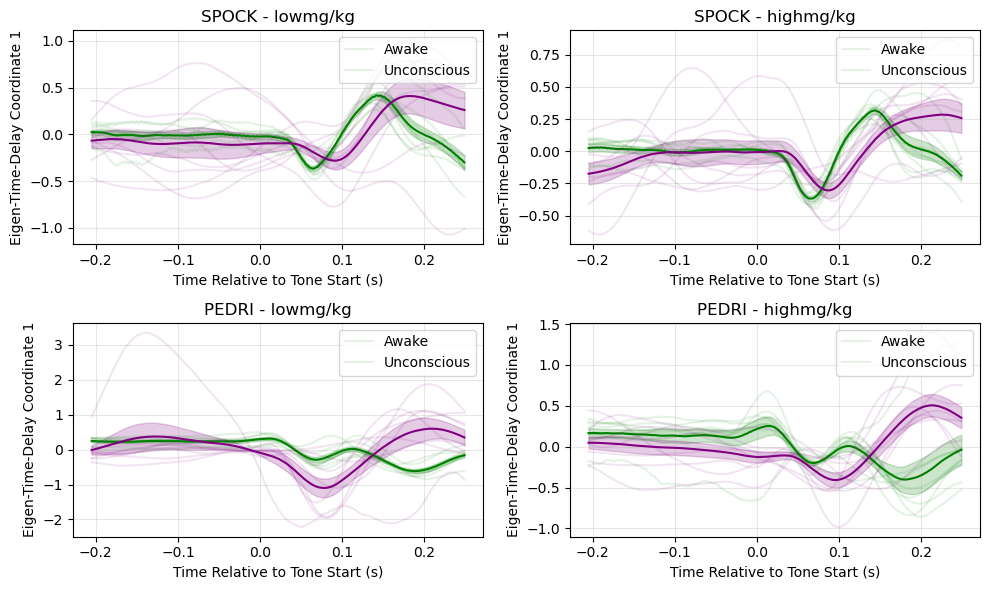

In [20]:
time_vals = np.arange(-leadup + (n_delays - 1)*delay_interval, response)*dt

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for monkey in responses_etdc.keys():
    for dose in responses_etdc[monkey].keys():
        if monkey == 'SPOCK':
            ax_idx = (0, 0) if dose == 'low' else (0, 1)
        else:  # PEDRI
            ax_idx = (1, 0) if dose == 'low' else (1, 1)
            
        for section in responses_etdc[monkey][dose].keys():
            mean_trajectory = responses_etdc[monkey][dose][section].mean(axis=0)[:, 0]
            sem_trajectory = responses_etdc[monkey][dose][section].std(axis=0)[:, 0] / np.sqrt(responses_etdc[monkey][dose][section].shape[0])
            
            color = 'green' if 'awake' in section else 'purple'
            
            # Plot individual trajectories
            for i in range(responses_etdc[monkey][dose][section].shape[0]):
                axs[ax_idx].plot(time_vals, responses_etdc[monkey][dose][section][i, :, 0], 
                               color=color, alpha=0.1)
            
            # Plot mean and standard error
            axs[ax_idx].plot(time_vals, mean_trajectory, color=color)
            axs[ax_idx].fill_between(time_vals, 
                                   mean_trajectory - sem_trajectory,
                                   mean_trajectory + sem_trajectory,
                                   color=color, alpha=0.2)
            
        axs[ax_idx].set_title(f'{monkey} - {dose}mg/kg')
        axs[ax_idx].set_xlabel('Time Relative to Tone Start (s)')
        axs[ax_idx].set_ylabel('Eigen-Time-Delay Coordinate 1')
        axs[ax_idx].legend(['Awake', 'Unconscious'], loc='upper right')
        axs[ax_idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
